# Introduction

<h1>Text-Based Category Classification</h1>
<h3>Author: Alfian Rahman</h3>

<p>When dealing with Natural Language Processing (NLP), sometimes we will face multi-class classification problems. These typical problems can be solved in several ways such as using LSTM model. In this case, I use a dataset from <a href="http://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv">BBC</a> that can be used to learn text classification.</p> 

# Import Modules and File

<p>First, before we begin the data exploration, we will import the needed modules:

**matplotlib**: to create data visualization. </br>
**pandas**: to manipulate data. </br>
**sklearn**: to split the training and validation dataset. </br>
**tensorflow**: to tokenize and pad the texts and to build the model. </br>
**wordcloud**: to visualize the top frequent words.
</p>

In [137]:
import os
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud

# Set seaborn as plotting style (just a matter of preference)
plt.style.use("seaborn")

# Set the global random seed for TensorFlow (to maintain the reproducibility)
tf.random.set_seed(100) 

<p>After we finish the modules import, the next step is reading the file. We can read the files from local or directly from the <a href="http://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv">API</a>. Because the dataset is relatively small (4.9 MB), in this case, we directly import from the <a href="http://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv">API</a>. If you want to import the dataset from local, I already include the file in the same folder with this notebook.</p>

In [138]:
df = pd.read_csv("http://storage.googleapis.com/dataset-uploader/bbc/" +
                 "bbc-text.csv")

# Use this if you want to import the dataset from local
# df = pd.read_csv("bbc_text.csv")

# Exploratory Data Analysis (EDA)

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


<p>From the above information, we can infer that the dataset has 2225 rows and 2 columns with an object (string) data type. There is no null value in each column. The category column will be used to classify the text column.</br>

So, we can say that the text column is the feature and the category column is the classification target.</p>



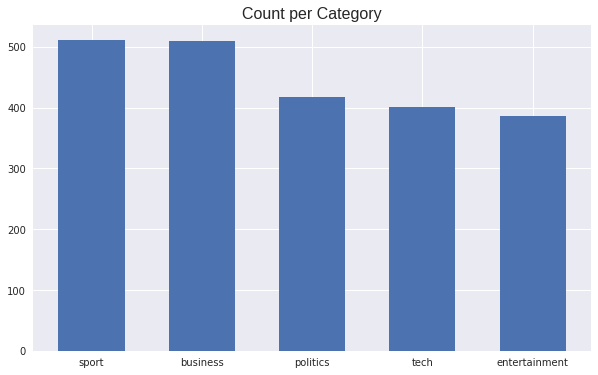

In [140]:
df_categories = df["category"].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(df_categories.index, df_categories.values, 0.6)
plt.xticks(fontname="roboto")
plt.yticks(fontname="roboto")
plt.title("Count per Category", fontdict={"fontsize": 16})
plt.show()

<p>From the above figure, we can see that we don't encounter imbalanced problems. Each category has enough samples to train. Let's dive deeper to the dataset. Let's see the first 10 rows.</p>

In [141]:
df.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


<p>We can see that the text column shows articles' snapshots from news. The words that are related to their category. For example, in row 1, the text uses words "tv" and "future" which are parts of business words.</p> 
<p>On the other hand, there is also an entertainment category which may includes the "tv" word. This leads to problems when creating the model. So, we need to merge these categories into one category. We'll also blend the entertainment and sport categories because some words in these 2 categories are interchangable.</p>
<p>Let's see which words come frequently.</p>

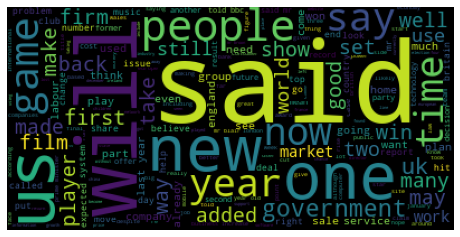

In [142]:
word_cloud = WordCloud().generate(' '.join(df['text']))

plt.figure()
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

<p> It turns out the words "said", "will", "people", and "game" are the top words. </p>

# Data Preprocessing

As we've discussed earlier, we will merge some categories into one to make a more precise model. We'll merge "tech" and "business" category to "Tech & Business" category. Also, we'll combine the "sport" and "entertainment" to "Sport and Entertainment".

In [143]:
df["category"] = df["category"].replace({"tech": "Tech & Business", 
                                         "business": "Tech & Business", 
                                         "sport": "Sport & Entertainment", 
                                         "entertainment": 
                                         "Sport & Entertainment", 
                                         "politics": "Politics"})

In [144]:
df.head()

,category,text
0,Tech & Business,tv future in the hands of viewers with home th...
1,Tech & Business,worldcom boss left books alone former worldc...
2,Sport & Entertainment,tigers wary of farrell gamble leicester say ...
3,Sport & Entertainment,yeading face newcastle in fa cup premiership s...
4,Sport & Entertainment,ocean s twelve raids box office ocean s twelve...


<p>Because TensorFlow works in Tensor, we need to convert each categories to number 1 or 0. This process is normally called one-hot encoding.</p>

In [145]:
df_labels = pd.get_dummies(df['category'])
df = pd.concat([df, df_labels], axis=1)
df = df.drop(columns='category')

In [146]:
df.head()

,text,Politics,Sport & Entertainment,Tech & Business
0,tv future in the hands of viewers with home th...,0,0,1
1,worldcom boss left books alone former worldc...,0,0,1
2,tigers wary of farrell gamble leicester say ...,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0


In [147]:
X = df['text'].values 
y = df[['Politics', 'Sport & Entertainment', 'Tech & Business']].values 

print("After one hot encoding (top 5 rows) \n")
print("text: ")
print(X[:5], "\n")
print("category: ")
print(y[:5])

After one hot encoding (top 5 rows) 

text: 
['tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more persona

<p>Since we're ready enough to build the model, let's split the dataset into train (<b>X</b>) and test (<b>y</b>) dataset. In this example, we use 20% of the dataset as test dataset.</p>

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<p>After splitting the data, the next step is tokenizing and passing the data. Tokenizing means we convert the data from texts to sequence of numbers. Padding means we convert the data to the same size. In this case, we will only include 5000 top words.</p>

In [149]:
tokenizer = Tokenizer(5000, oov_token='x')

tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)

In [150]:
print("Text sample (first row) before tokenizing: ")
print(X_train[0],"\n")
print("Text sample (first row) after tokenizing: ")
print(seq_train[0])

Text sample (first row) before tokenizing: 
oil companies get russian setback international oil and mining companies have reacted cautiously to russia s decision to bar foreign firms from natural resource tenders in 2005.  us oil giant exxon said it did not plan to take part in a new tender on a project for which it had previously signed a preliminary agreement. miner highland gold said it regretted any limit on privatisation while bp  a big investor  declined to comment. only firms at least 51% russian-owned will be permitted to bid.  the federal natural resources agency said  the government is interested in letting russian companies develop strategic resources . the foreign ownership issue will be dealt with according to russia s competition law  natural resources minister yuri trutnev was quoted as saying by the interfax news agency. no further details were given  with mr trutnev suggesting that russia may decide on a case-by-case basis. observers said that the move may represent a 

<p>After tokenizing, then comes padding. To pad the data, we determine the maximum length by selecting the maximum of training and test data sequence length.</p>


In [151]:
def get_seq_length_avg(seq):
    """
    Functions to get the average tokens length in a sequence (list).

    Parameter
    seq (list) : A list or sequence in the shape of (m, n) or 2D. 

    Return 
    seq_avg_length (int) : The average of length in a list or sequence.
    """
    seq_length = [len(i) for i in seq]
    seq_length_avg = int(sum(seq_length)/len(seq_length))
    return seq_length_avg

In [152]:
seq_train_length_avg = get_seq_length_avg(seq_train)
seq_test_length_avg = get_seq_length_avg(seq_test)

max_shape = max(seq_train_length_avg, seq_test_length_avg)

pad_train = pad_sequences(seq_train, max_shape)
pad_test = pad_sequences(seq_test, max_shape)

In [153]:
print("The padding size (maximum length): ", max_shape, "\n")
print("Sequence sample (second row) before padding: ", seq_train[1], "\n")
print("Sequence sample (second row) after padding: ", pad_train[1], "\n")

The padding size (maximum length):  394 

Sequence sample (second row) before padding:  [2730, 3, 600, 50, 2432, 148, 2730, 2, 70, 8, 336, 2730, 124, 20, 624, 3, 600, 2730, 2432, 124, 2730, 9, 2730, 2730, 7, 35, 59, 583, 223, 340, 2730, 8, 82, 577, 2129, 465, 2730, 2730, 5, 2730, 2730, 12, 198, 20, 6, 50, 2730, 2481, 2730, 2730, 4670, 2730, 2730, 14, 12, 1844, 3, 91, 50, 4202, 2057, 9, 2, 223, 210, 2, 65, 408, 4, 219, 12, 14, 2730, 37, 17, 2730, 77, 44, 1409, 50, 2432, 248, 2, 50, 2432, 120, 3043, 6, 201, 877, 9, 2730, 18, 2730, 2730, 5, 3298, 4341, 14, 2730, 1023, 903, 294, 4866, 2730, 7, 1254, 2730, 36, 10, 2525, 13, 2, 206, 631, 799, 636, 35, 677, 4671, 4, 4342, 2730, 132, 28, 4867, 2730, 6, 42, 360, 12, 2244, 6, 4069, 447, 9, 44, 949, 4671, 7, 2, 42, 3377, 1548, 334, 246, 2730, 636, 1711, 4, 2730, 2302] 

Sequence sample (second row) after padding:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

# Building the Model

<p> Here, we will use TensorFlow to build the model. The layers that we use are Embedding, SpatialDropout1D, Bidirectional, LSTM, and Dense. 

**Embedding**: To embed the sequence. </br>
**SpatialDropout1D** & **Dropout**: To prevent overfitting. </br>
**Bidirectional** & **LSTM**: To improve the training by considering the words order. </br>
**Dense**: To normally train the model by neural network.</br> 

We also build a class called **ModelTrainingCallback** that inherited from **tf.keras.callbacks.Callback** to stop the training when the training and validation accuracies are greater than 0.9.


In [154]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.SpatialDropout1D(0.4), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.4, 
                                                       recurrent_dropout=0.4)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4), 
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'), 
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',
              metrics=['accuracy'])

In [155]:
class ModelTrainingCallback(tf.keras.callbacks.Callback):
    """
    A callback class to stop the training when the conditions are fulfilled.
    """
    def on_epoch_end(self, epoch, logs={}):
        """
        Parameter 
        logs (dict) : The model training logs.
        """
        if(logs.get("accuracy") > 0.9 and logs.get("val_accuracy") > 0.9):
            print("Both of the train and validation accuracies are already " +
            "greater than 0.9. Model training is ended.")
            self.model.stop_training = True

callbacks = ModelTrainingCallback()

# Training the Model

In [156]:
num_epochs = 20
batch_size = 64

history = model.fit(pad_train, y_train, epochs=num_epochs, 
                    batch_size=batch_size, validation_data=(pad_test, y_test), 
                    callbacks=callbacks)

Epoch 1/20
28/28 [==============================] - 27s 958ms/step - loss: 1.0813 - accuracy: 0.3860 - val_loss: 1.0431 - val_accuracy: 0.4090
Epoch 2/20
28/28 [==============================] - 26s 940ms/step - loss: 1.0260 - accuracy: 0.4146 - val_loss: 1.0408 - val_accuracy: 0.4607
Epoch 3/20
28/28 [==============================] - 26s 940ms/step - loss: 1.0105 - accuracy: 0.4607 - val_loss: 1.0230 - val_accuracy: 0.4607
Epoch 4/20
28/28 [==============================] - 26s 934ms/step - loss: 0.9732 - accuracy: 0.4663 - val_loss: 0.9120 - val_accuracy: 0.5865
Epoch 5/20
28/28 [==============================] - 26s 937ms/step - loss: 0.8149 - accuracy: 0.5815 - val_loss: 0.7316 - val_accuracy: 0.7281
Epoch 6/20
28/28 [==============================] - 26s 939ms/step - loss: 0.5945 - accuracy: 0.7663 - val_loss: 1.3633 - val_accuracy: 0.6449
Epoch 7/20
28/28 [==============================] - 31s 1s/step - loss: 0.5268 - accuracy: 0.7831 - val_loss: 0.5219 - val_accuracy: 0.8202
Ep

# Result

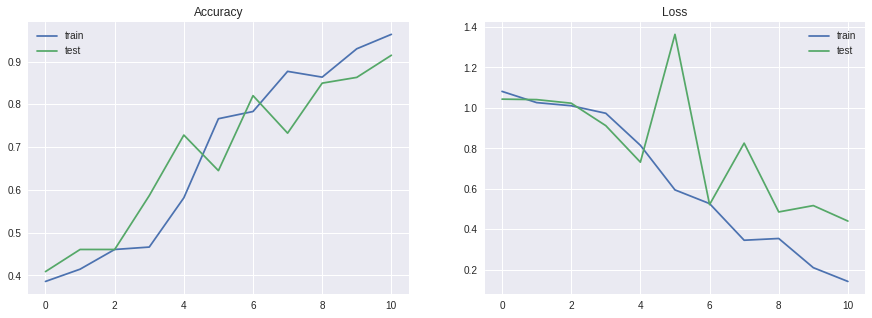

In [157]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="test")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.title("Loss")
plt.legend()
plt.show();